# Evaluation of Timit on RawNet trained on Large ASR

In [18]:
import numpy as np

import torch
from torch.utils import data

import torchaudio

import csv
import pandas as pd

import glob
from pathlib import Path

import os

In [58]:
CURRENT_WORKING_DIRECTORY = "W:/SpeakerRecognitionResearch/"

TIMIT_DATASET_DIRECTORY = "S:/timit/data/"
TIMIT_LABELS_FILE = "notebooks/EvaluateTimitRawNetLargeAsr/SincNetDatasetSplits/TIMIT_labels.npy"
TIMIT_TEST_LIST_FILE = "notebooks/EvaluateTimitRawNetLargeAsr/SincNetDatasetSplits/TIMIT_test.scp"

# To avoid file location related errors, we make sure "SpeakerRecognitionResearch" root folder is the current working directory.
os.chdir(CURRENT_WORKING_DIRECTORY)
os.getcwd()

'W:\\SpeakerRecognitionResearch'

In [59]:
# The lists provided in SincNet have the paths in lowercase while the paths in the dataset are capital case.
# We mitigate this by converting the list into higher case

wav_path_list = []
with open(TIMIT_TEST_LIST_FILE) as f:
    for line in f.readlines():
        wav_path_list.append(line.strip())

for i in range(len(wav_path_list)):
    wav_path_list[i] = wav_path_list[i].upper()

print("Total test wavs:", len(wav_path_list))

Total test wavs: 1386


In [60]:
path_to_spk_dict = np.load(TIMIT_LABELS_FILE, allow_pickle=True).item()
type(path_to_spk_dict)

dict

In [61]:
all_speakers = [path_to_spk_dict[path.lower()] for path in wav_path_list]
len(all_speakers)

1386

In [62]:
# Device

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {}.".format(device))
if device=="cuda": print(torch.cuda.get_device_name(0))

Using cuda.
NVIDIA GeForce RTX 3070 Ti


# 1. Loading the Dataset

In [63]:
# If sample_rate = 16K and number_of_samples = 32000, then each tensor will be equivalent to 2 seconds of data
SAMPLE_RATE = 16000
NUMBER_OF_SAMPLES = 32000

# Bangla ASR Dataset has around half of second of silence in the beginning
# This constant will be used to cut samples from the left of the audio
TRIM_AMOUNT_TIME = 0.3

In [64]:
# Using default parameter values used in the VoxCeleb Dataset

SAMPLE_RATE = 16000
NUMBER_OF_SAMPLES = 32000

In [68]:
class TimitDataset(data.Dataset):
    def __init__(self, dataset_dir, wav_path_list, path_to_spk_dict, target_sample_rate, target_num_samples, trim_amount_time, device, is_evalset=False):

        # wav_list will have a list of stems that will be included in this dataset

        self.dataset_dir = dataset_dir
        self.path_to_spk_dict = path_to_spk_dict
        self.wav_path_list = wav_path_list
        self.target_sample_rate = target_sample_rate
        self.target_num_samples = target_num_samples
        self.trim_amount_time = trim_amount_time
        self.device = device
        self.is_evalset=is_evalset

    def _resample_to_target_sr(self, signal, sample_rate):
        if sample_rate != self.target_sample_rate:
            resampler = torchaudio.transforms.Resample(sample_rate, self.target_sample_rate)
            signal = resampler(signal)
        return signal

    def _mix_down_to_mono(self, signal):
        if signal.shape[0] > 1:
            signal = torch.mean(signal, dim=0, keepdim=True)
        return signal

    def _trim(self, signal):
        total_samples = signal.shape[-1]

        # We cut a fixed amount on the left side if the signal is big enough
        trim_samples_amount = int(self.target_sample_rate * self.trim_amount_time)

        if total_samples >= trim_samples_amount + self.target_num_samples:
            signal = signal[: , trim_samples_amount:]
            total_samples = signal.shape[-1]

        # We cut from the right side if the signal is too big
        if total_samples > self.target_num_samples:
            signal = signal[:, :self.target_num_samples]
        
        # We add zero padding on the right if signal is too small
        if total_samples < self.target_num_samples:
            num_missing_samples = self.target_num_samples - total_samples
            last_dim_padding = (0, num_missing_samples)
            signal = torch.nn.functional.pad(signal, last_dim_padding)
            
        return signal

    def _normalize_like_sincnet(self, signal):
        return signal/torch.max(torch.abs(signal))

    def __len__(self):
        return len(self.wav_path_list)

    def __getitem__(self, index):
        wav_path = self.wav_path_list[index]
        label_index = self.path_to_spk_dict[wav_path.lower()]

        signal, sample_rate = torchaudio.load( self.dataset_dir + wav_path)

        # moving to CPU/CUDA is now done in the training phase
        # signal = signal.to(self.device)

        signal = self._resample_to_target_sr(signal, sample_rate)
        signal = self._mix_down_to_mono(signal)

        signal =  self._trim(signal)
        signal = self._normalize_like_sincnet(signal)

        # signal = signal.squeeze(0)

        if self.is_evalset:
            return signal, label_index, wav_path
        else:
            return signal, label_index
        

In [69]:
timit_dataset = TimitDataset(
    dataset_dir=TIMIT_DATASET_DIRECTORY,
    wav_path_list=wav_path_list,
    path_to_spk_dict=path_to_spk_dict,
    target_sample_rate=SAMPLE_RATE,
    target_num_samples=NUMBER_OF_SAMPLES,
    trim_amount_time=TRIM_AMOUNT_TIME,
    device=device,
    is_evalset=True
)

In [73]:
timit_dataset[100]

(tensor([[ 0.0054, -0.0214,  0.0404,  ...,  0.0077, -0.0152,  0.0006]]),
 33,
 'TRAIN/DR1/MTJS0/SI1822.WAV')

# RawNet2 Model

In [110]:
from torch import nn
from torchsummary import summary

import numpy as np
import math

import torch.nn.functional as F
from tqdm import tqdm

In [111]:
class FRM(nn.Module):
    def __init__(self, nb_dim, do_add = True, do_mul = True):
        super(FRM, self).__init__()
        self.fc = nn.Linear(nb_dim, nb_dim)
        self.sig = nn.Sigmoid()
        self.do_add = do_add
        self.do_mul = do_mul
    def forward(self, x):
        y = F.adaptive_avg_pool1d(x, 1).view(x.size(0), -1)
        
        y = self.sig(self.fc(y)).view(x.size(0), x.size(1), -1)

        if self.do_mul: x = x * y
        if self.do_add: x = x + y
        return x

In [112]:
class Residual_block_wFRM(nn.Module):
    def __init__(self, nb_filts, first = False):
        super(Residual_block_wFRM, self).__init__()
        self.first = first
        if not self.first:
            self.bn1 = nn.BatchNorm1d(num_features = nb_filts[0])
        self.lrelu = nn.LeakyReLU()
        self.lrelu_keras = nn.LeakyReLU(negative_slope=0.3)
        
        self.conv1 = nn.Conv1d(in_channels = nb_filts[0],
            out_channels = nb_filts[1],
            kernel_size = 3,
            padding = 1,
            stride = 1)
        self.bn2 = nn.BatchNorm1d(num_features = nb_filts[1])
        self.conv2 = nn.Conv1d(in_channels = nb_filts[1],
            out_channels = nb_filts[1],
            padding = 1,
            kernel_size = 3,
            stride = 1)
        
        if nb_filts[0] != nb_filts[1]:
            self.downsample = True
            self.conv_downsample = nn.Conv1d(in_channels = nb_filts[0],
                out_channels = nb_filts[1],
                padding = 0,
                kernel_size = 1,
                stride = 1)
            
        else:
            self.downsample = False
        self.mp = nn.MaxPool1d(3)
        self.frm = FRM(
            nb_dim = nb_filts[1],
            do_add = True,
            do_mul = True)
        
    def forward(self, x):
        identity = x
        if not self.first:
            out = self.bn1(x)
            out = self.lrelu_keras(out)
        else:
            out = x
            
        out = self.conv1(out)
        out = self.bn2(out)
        out = self.lrelu_keras(out)
        out = self.conv2(out)
        
        if self.downsample:
            identity = self.conv_downsample(identity)
            
        out += identity
        out = self.mp(out)
        out = self.frm(out)
        return out

In [113]:
class LayerNorm(nn.Module):

    def __init__(self, features, eps=1e-6):
        super(LayerNorm,self).__init__()
        self.gamma = nn.Parameter(torch.ones(features))
        self.beta = nn.Parameter(torch.zeros(features))
        self.eps = eps

    def forward(self, x):
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        return self.gamma * (x - mean) / (std + self.eps) + self.beta

In [114]:
class SincConv_fast(nn.Module):
    """Sinc-based convolution
    Parameters
    ----------
    in_channels : `int`
        Number of input channels. Must be 1.
    out_channels : `int`
        Number of filters.
    kernel_size : `int`
        Filter length.
    sample_rate : `int`, optional
        Sample rate. Defaults to 16000.
    Usage
    -----
    See `torch.nn.Conv1d`
    Reference
    ---------
    Mirco Ravanelli, Yoshua Bengio,
    "Speaker Recognition from raw waveform with SincNet".
    https://arxiv.org/abs/1808.00158
    """

    @staticmethod
    def to_mel(hz):
        return 2595 * np.log10(1 + hz / 700)

    @staticmethod
    def to_hz(mel):
        return 700 * (10 ** (mel / 2595) - 1)

    def __init__(self, out_channels, kernel_size, sample_rate=16000, in_channels=1,
                 stride=1, padding=0, dilation=1, bias=False, groups=1, min_low_hz=50, min_band_hz=50):

        super(SincConv_fast,self).__init__()

        if in_channels != 1:
            #msg = (f'SincConv only support one input channel '
            #       f'(here, in_channels = {in_channels:d}).')
            msg = "SincConv only support one input channel (here, in_channels = {%i})" % (in_channels)
            raise ValueError(msg)

        self.out_channels = out_channels
        self.kernel_size = kernel_size
        
        # Forcing the filters to be odd (i.e, perfectly symmetrics)
        if kernel_size%2==0:
            self.kernel_size=self.kernel_size+1
            
        self.stride = stride
        self.padding = padding
        self.dilation = dilation

        if bias:
            raise ValueError('SincConv does not support bias.')
        if groups > 1:
            raise ValueError('SincConv does not support groups.')

        self.sample_rate = sample_rate
        self.min_low_hz = min_low_hz
        self.min_band_hz = min_band_hz

        # initialize filterbanks such that they are equally spaced in Mel scale
        low_hz = 30
        high_hz = self.sample_rate / 2 - (self.min_low_hz + self.min_band_hz)

        mel = np.linspace(self.to_mel(low_hz),
                          self.to_mel(high_hz),
                          self.out_channels + 1)
        hz = self.to_hz(mel)
        

        # filter lower frequency (out_channels, 1)
        self.low_hz_ = nn.Parameter(torch.Tensor(hz[:-1]).view(-1, 1))

        # filter frequency band (out_channels, 1)
        self.band_hz_ = nn.Parameter(torch.Tensor(np.diff(hz)).view(-1, 1))

        # Hamming window
        #self.window_ = torch.hamming_window(self.kernel_size)
        n_lin=torch.linspace(0, (self.kernel_size/2)-1, steps=int((self.kernel_size/2))) # computing only half of the window
        self.window_=0.54-0.46*torch.cos(2*math.pi*n_lin/self.kernel_size);

        # (1, kernel_size/2)
        n = (self.kernel_size - 1) / 2.0
        self.n_ = 2*math.pi*torch.arange(-n, 0).view(1, -1) / self.sample_rate # Due to symmetry, I only need half of the time axes

    def forward(self, waveforms):
        """
        Parameters
        ----------
        waveforms : `torch.Tensor` (batch_size, 1, n_samples)
            Batch of waveforms.
        Returns
        -------
        features : `torch.Tensor` (batch_size, out_channels, n_samples_out)
            Batch of sinc filters activations.
        """

        self.n_ = self.n_.to(waveforms.device)

        self.window_ = self.window_.to(waveforms.device)

        low = self.min_low_hz  + torch.abs(self.low_hz_)
        
        high = torch.clamp(low + self.min_band_hz + torch.abs(self.band_hz_),self.min_low_hz,self.sample_rate/2)
        band=(high-low)[:,0]
        
        f_times_t_low = torch.matmul(low, self.n_)
        f_times_t_high = torch.matmul(high, self.n_)

        band_pass_left=((torch.sin(f_times_t_high)-torch.sin(f_times_t_low))/(self.n_/2))*self.window_ # Equivalent of Eq.4 of the reference paper (SPEAKER RECOGNITION FROM RAW WAVEFORM WITH SINCNET). I just have expanded the sinc and simplified the terms. This way I avoid several useless computations. 
        band_pass_center = 2*band.view(-1,1)
        band_pass_right= torch.flip(band_pass_left,dims=[1])
        
        
        band_pass=torch.cat([band_pass_left,band_pass_center,band_pass_right],dim=1)

        
        band_pass = band_pass / (2*band[:,None])
        

        self.filters = (band_pass).view(
            self.out_channels, 1, self.kernel_size)

        return F.conv1d(waveforms, self.filters, stride=self.stride,
                        padding=self.padding, dilation=self.dilation,
                         bias=None, groups=1)

In [115]:
class RawNet2(nn.Module):
    def __init__(self, d_args):
        super(RawNet2, self).__init__()

        self.ln = LayerNorm(d_args['nb_samp'])
        self.first_conv = SincConv_fast(in_channels = d_args['in_channels'],
            out_channels = d_args['filts'][0],
            kernel_size = d_args['first_conv']
            )
        
        self.first_bn = nn.BatchNorm1d(num_features = d_args['filts'][0])
        self.lrelu = nn.LeakyReLU()
        self.lrelu_keras = nn.LeakyReLU(negative_slope = 0.3)
        
        self.block0 = nn.Sequential(Residual_block_wFRM(nb_filts = d_args['filts'][1], first = True))
        self.block1 = nn.Sequential(Residual_block_wFRM(nb_filts = d_args['filts'][1]))
 
        self.block2 = nn.Sequential(Residual_block_wFRM(nb_filts = d_args['filts'][2]))
        d_args['filts'][2][0] = d_args['filts'][2][1]
        self.block3 = nn.Sequential(Residual_block_wFRM(nb_filts = d_args['filts'][2]))
        self.block4 = nn.Sequential(Residual_block_wFRM(nb_filts = d_args['filts'][2]))
        self.block5 = nn.Sequential(Residual_block_wFRM(nb_filts = d_args['filts'][2]))
        self.avgpool = nn.AdaptiveAvgPool1d(1)

        self.bn_before_gru = nn.BatchNorm1d(num_features = d_args['filts'][2][-1])
        self.gru = nn.GRU(input_size = d_args['filts'][2][-1],
            hidden_size = d_args['gru_node'],
            num_layers = d_args['nb_gru_layer'],
            batch_first = True)

        
        self.fc1_gru = nn.Linear(in_features = d_args['gru_node'],
            out_features = d_args['nb_fc_node'])
        self.fc2_gru = nn.Linear(in_features = d_args['nb_fc_node'],
            out_features = d_args['nb_classes'],
            bias = True)
        
        self.sig = nn.Sigmoid()
        
    def forward(self, x, y = 0, is_test=False):
        #follow sincNet recipe
        nb_samp = x.shape[0]
        len_seq = x.shape[1]

        x = self.ln(x)
        x=x.view(nb_samp,1,len_seq)
        x = F.max_pool1d(torch.abs(self.first_conv(x)), 3)
        x = self.first_bn(x)
        x = self.lrelu_keras(x)
        
        x = self.block0(x)
        x = self.block1(x)

        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = self.block5(x)

        x = self.bn_before_gru(x)
        x = self.lrelu_keras(x)
        x = x.permute(0, 2, 1)  #(batch, filt, time) >> (batch, time, filt)
        self.gru.flatten_parameters()
        x, _ = self.gru(x)
        x = x[:,-1,:]
        code = self.fc1_gru(x)
        if is_test: return code
        
        code_norm = code.norm(p=2,dim=1, keepdim=True) / 10.
        code = torch.div(code, code_norm)
        out = self.fc2_gru(code)
        return out

# 3. Loading RawNet with Large ASR Weights

In [117]:
import torch

import pickle

In [118]:
RAWNET2_LARGE_ASR_WEIGHTS_LOCATION = "notebooks/TrainLargeAsrOnRawNet2/out/models/outmodel_epoch_14.pth"

In [119]:
# Default value was 8, however NoteBook doesn't support >0
NB_WORKER = 0

In [120]:
model_dict = {}
# We have used 2771 classes from the Large Asr to train RawNet model
model_dict['nb_classes'] = 2764
model_dict['first_conv'] = 251
model_dict['in_channels'] = 1
model_dict['filts'] = [128, [128,128], [128,128], [256,256]]
model_dict['m_blocks'] = [2, 4]
model_dict['nb_fc_att_node'] =[1]
model_dict['nb_fc_node'] = 1024
model_dict['gru_node'] = 1024
model_dict['nb_gru_layer'] = 1
model_dict['nb_samp'] = NUMBER_OF_SAMPLES

model_dict['lr_decay'] = "keras"
model_dict['do_lr_decay'] = True

In [123]:
model = RawNet2(model_dict)
checkpoint = torch.load(RAWNET2_LARGE_ASR_WEIGHTS_LOCATION, map_location=torch.device("cpu"))
model.load_state_dict(checkpoint['model_state_dict'])
model.to(device)

RawNet2(
  (ln): LayerNorm()
  (first_conv): SincConv_fast()
  (first_bn): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (lrelu): LeakyReLU(negative_slope=0.01)
  (lrelu_keras): LeakyReLU(negative_slope=0.3)
  (block0): Sequential(
    (0): Residual_block_wFRM(
      (lrelu): LeakyReLU(negative_slope=0.01)
      (lrelu_keras): LeakyReLU(negative_slope=0.3)
      (conv1): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=(1,))
      (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=(1,))
      (mp): MaxPool1d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
      (frm): FRM(
        (fc): Linear(in_features=128, out_features=128, bias=True)
        (sig): Sigmoid()
      )
    )
  )
  (block1): Sequential(
    (0): Residual_block_wFRM(
      (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats

In [124]:
# Create DataLoader for Dataset

timit_dataloader = data.DataLoader(timit_dataset,
            batch_size = 1, 
            shuffle = False,
            drop_last = False,
            num_workers = NB_WORKER)

# 4. Extract Embeddings

In [125]:
EMBEDDINGS_SAVE_FILE_LOCATION = "notebooks/EvaluateTimitRawNetLargeAsr/out/embeddings.pkl"

In [126]:
# Model must be in eval mode to extract embedding

model.eval()

RawNet2(
  (ln): LayerNorm()
  (first_conv): SincConv_fast()
  (first_bn): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (lrelu): LeakyReLU(negative_slope=0.01)
  (lrelu_keras): LeakyReLU(negative_slope=0.3)
  (block0): Sequential(
    (0): Residual_block_wFRM(
      (lrelu): LeakyReLU(negative_slope=0.01)
      (lrelu_keras): LeakyReLU(negative_slope=0.3)
      (conv1): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=(1,))
      (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=(1,))
      (mp): MaxPool1d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
      (frm): FRM(
        (fc): Linear(in_features=128, out_features=128, bias=True)
        (sig): Sigmoid()
      )
    )
  )
  (block1): Sequential(
    (0): Residual_block_wFRM(
      (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats

In [129]:
user_choice = input("Do You Want To Generate Embeddings? Type YES/NO")

if user_choice == "YES":
    #Generating Embeddings
    with torch.set_grad_enabled(False):
        #1st, extract speaker embeddings.

        # Each m_batch is a single wav
        with open(EMBEDDINGS_SAVE_FILE_LOCATION, 'ab+') as fp:
            for m_batch in tqdm(timit_dataloader, total=len(wav_path_list)):
                l_code = []
                for batch in m_batch[0]:
                    batch = batch.to(device)
                    code = model(x = batch, is_test=True)
                    l_code.extend(code.cpu().numpy())
                file_location = m_batch[2][0]
                l_embedding = np.mean(l_code, axis=0)
                pickle.dump((file_location, l_embedding), fp)

  0%|          | 0/1386 [00:00<?, ?it/s]C:\Users\molla\.conda\envs\pytorch\lib\site-packages\torch\nn\functional.py:652: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool1d(input, kernel_size, stride, padding, dilation, ceil_mode)
100%|██████████| 1386/1386 [00:12<00:00, 112.08it/s]


In [130]:
# Load from pickle
# embeddings[path] = numpy_array

embeddings = {}
with open(EMBEDDINGS_SAVE_FILE_LOCATION, 'rb') as fr:
    try:
        while True:
            data = pickle.load(fr)
            embeddings[data[0]] = data[1]
    except EOFError:
        pass
len(embeddings.keys())

1386

In [131]:
embeddings[list(embeddings.keys())[0]]

array([ 0.9363995 , -0.30366653,  0.52073425, ...,  1.2147985 ,
       -0.82698315,  0.47207832], dtype=float32)

In [132]:
def speech_per_speaker(path_to_spk_dict):
    # Returns a dictionary containing the number of utterrances for each speaker
    speaker_ids = {}
    for wav in path_to_spk_dict.keys():
        spk_id = path_to_spk_dict[wav]
        if spk_id in speaker_ids.keys():
            speaker_ids[spk_id] += 1
        else:
            speaker_ids[spk_id] = 0

    return speaker_ids

In [134]:
speech_per_spk = speech_per_speaker(path_to_spk_dict)
total_number_of_speakers = len(speech_per_spk.keys())

# This is the total number of speakers in this dataset
total_number_of_speakers

462

# 5. Evaluate Timit RawNet2 Trained on Large Asr

In [135]:
from sklearn.metrics import roc_curve
from scipy.optimize import brentq
from scipy.interpolate import interp1d

In [159]:
# Specifies how many trials to make
# In other words, how many times to calculate cos_sim to calculate EER
NB_TRIALS = 10000

# Where the validation trials should be saved
VAL_TRIAL_LOCATION = "notebooks/EvaluateTimitRawNetLargeAsr/SincNetDatasetSplits/val_trials.txt"

In [160]:
def cos_sim(a,b):
    return np.dot(a,b) / (np.linalg.norm(a) * np.linalg.norm(b))

In [161]:
first_key = list(embeddings.keys())[0]
second_key = list(embeddings.keys())[50]

cos_sim(embeddings[first_key], embeddings[second_key])

0.41225228

In [162]:
def get_speaker_to_paths_dict(wav_path_list, path_to_spk_dict):
    
    spk_to_path_d = {}

    for wav_path in wav_path_list:
        spk_id = path_to_spk_dict[wav_path.lower()]

        if spk_id in spk_to_path_d.keys():
            spk_to_path_d[spk_id].append(wav_path)
        else:
            spk_to_path_d[spk_id] = [wav_path]
    
    return spk_to_path_d

In [154]:
spk_to_paths_d = get_speaker_to_paths_dict(wav_path_list, path_to_spk_dict)

spk_to_paths_d[1]

['TRAIN/DR1/FDAW0/SI1271.WAV',
 'TRAIN/DR1/FDAW0/SI1406.WAV',
 'TRAIN/DR1/FDAW0/SI2036.WAV']

In [155]:
# This function will generate a file that will contain which two files should be compared with cos similarities
# Format:
# 1 spk/_1_/audio/1.wav spk/_1_/audio/2.wav
# 0 spk/_1_/audio/1.wav spk/_2_/audio/1.wav

def generate_validation_trials(wav_path_list, nb_trial, val_trial_location, speaker_to_paths_d):
    val_trial_file = open(val_trial_location, 'w')

    # We define, same speaker trial as target trial
    # Target trial: 1; Non-trg: 0

    # There will be equal numbers of target and non target trials
    nb_target_trials = int(nb_trial / 2)
        
    speakers_list = list(speaker_to_paths_d.keys())

    #compose target trials
    selected_spks = np.random.choice(speakers_list, size=nb_target_trials, replace=True)
    for spk in selected_spks:
        wav_paths_of_speaker = speaker_to_paths_d[spk]
        utt_a, utt_b = np.random.choice(wav_paths_of_speaker, size=2, replace=False)
        val_trial_file.write('1 %s %s\n'%(utt_a, utt_b))

    #compose non-target trials
    for i in range(nb_target_trials):
        two_different_speakers = np.random.choice(speakers_list, size=2, replace = False)
        utt_a = np.random.choice(speaker_to_paths_d[two_different_speakers[0]], size=1)[0]
        utt_b = np.random.choice(speaker_to_paths_d[two_different_speakers[1]], size=1)[0]
        val_trial_file.write('0 %s %s\n'%(utt_a, utt_b))

    val_trial_file.close()

In [158]:
generate_validation_trials(wav_path_list=wav_path_list, 
                            nb_trial=NB_TRIALS, 
                            val_trial_location=VAL_TRIAL_LOCATION, 
                            speaker_to_paths_d=spk_to_paths_d)

In [163]:
# Retrieve validation trials from valtrial file
def get_validation_trials(val_trial_location):
    valtrials = []
    with open(val_trial_location, "r") as file:
        for line in file.readlines():
            line = line.rstrip("\n")
            splitted_line = line.split(" ")

            valtrials.append( (int(splitted_line[0]), splitted_line[1], splitted_line[2]) )

    return valtrials

In [170]:
validation_trials = get_validation_trials(VAL_TRIAL_LOCATION)
validation_trials[0]

(1, 'TRAIN/DR5/MDAS0/SI1266.WAV', 'TRAIN/DR5/MDAS0/SI636.WAV')

In [171]:
def get_y_true_and_score(validation_trials):
    y_true = [vt[0] for vt in validation_trials]
    y_score = []

    for vt in validation_trials:
        utt_1 = embeddings[vt[1]]
        utt_2 = embeddings[vt[2]]
        
        score = cos_sim(utt_1, utt_2)
        y_score.append(score)

    return y_true, y_score

In [172]:
y_true, y_score = get_y_true_and_score(validation_trials)

### EER Score

In [173]:
def calculate_eer(y_true, y_score):
    fpr, tpr, _  = roc_curve(y_true=y_true, y_score=y_score, pos_label=1)
    eer = brentq(lambda x: 1. - x - interp1d(fpr, tpr)(x), 0., 1.)
    return eer

In [174]:
eer = calculate_eer(y_true, y_score)
eer

0.1779999999990866

In [177]:
# Graph NB_SAMPLE / eer graph

eers = []
nb_trials = [i for i in range(500, 20000, 500)]

for nb_trial in nb_trials:
    print("Number of trials:", nb_trial, end=" ")
    generate_validation_trials(wav_path_list=wav_path_list, 
                            nb_trial=nb_trial, 
                            val_trial_location=VAL_TRIAL_LOCATION, 
                            speaker_to_paths_d=spk_to_paths_d)

    validation_trials = get_validation_trials(VAL_TRIAL_LOCATION)

    y_true, y_score = get_y_true_and_score(validation_trials)

    eer = calculate_eer(y_true, y_score)
    eers.append(eer)
    print("EER:", eer)
    

Number of trials: 500 EER: 0.15300000000000022
Number of trials: 1000 EER: 0.16800000000060783
Number of trials: 1500 EER: 0.14933333333154802
Number of trials: 2000 EER: 0.1512000000000106
Number of trials: 2500 EER: 0.18720000000000003
Number of trials: 3000 EER: 0.16466666666800336
Number of trials: 3500 EER: 0.1685714285714287
Number of trials: 4000 EER: 0.17749999999895993
Number of trials: 4500 EER: 0.1640000000001028
Number of trials: 5000 EER: 0.16679999999999998
Number of trials: 5500 EER: 0.17309090909184432
Number of trials: 6000 EER: 0.16333333333445532
Number of trials: 6500 EER: 0.1652307692306763
Number of trials: 7000 EER: 0.16735064935064914
Number of trials: 7500 EER: 0.1688
Number of trials: 8000 EER: 0.16900000000074555
Number of trials: 8500 EER: 0.16870588235293943
Number of trials: 9000 EER: 0.17367676767676776
Number of trials: 9500 EER: 0.16568421052632
Number of trials: 10000 EER: 0.1650285714285714
Number of trials: 10500 EER: 0.167047619047124
Number of tria

In [178]:
import matplotlib.pyplot as plt
from pylab import text
%matplotlib inline

Average EER: 0.16834445396327405


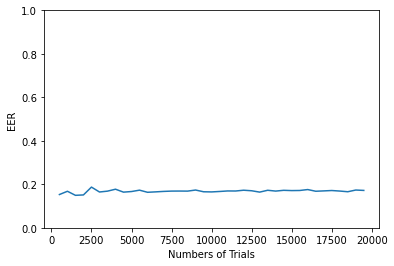

In [179]:
plt.plot(nb_trials, eers)
axes = plt.gca()
axes.set_xlabel("Numbers of Trials")
axes.set_ylabel("EER")
axes.set_ylim(0,1.0)

print("Average EER:", sum(eers)/len(eers))
